In [1]:
from tsfresh import extract_features
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import signal
import glob
import antropy
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from scipy.signal import butter, sosfilt, sosfreqz, detrend
import math
from scipy.signal import stft,find_peaks
from scipy.stats import kurtosis,skew


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
tf.random.set_seed(7)

In [6]:
sensor_ts_df = pd.read_parquet(r'./sensor_ts_df_4.parquet')

In [15]:
sensor_list = ['IMU_1_x','IMU_1_y','IMU_1_z','Prox','IMU_2_x','IMU_2_y','IMU_2_z']

In [8]:
session_lst = sensor_ts_df['File'].unique()

In [13]:
Train = sensor_ts_df.loc[sensor_ts_df['File'].isin(session_lst[:44])]
Valid = sensor_ts_df.loc[sensor_ts_df['File'].isin(session_lst[44:56])]
Test = sensor_ts_df.loc[sensor_ts_df['File'].isin(session_lst[56:72])]

In [76]:
Valid

,data_pt,label,label_chewing,label_eating,File,IMU_1_x,IMU_1_y,IMU_1_z,Prox,IMU_2_x,IMU_2_y,IMU_2_z
651301,0.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\7...,-0.069122,-0.039689,-0.167910,64.943283,0.029171,0.136023,0.105549
651302,1.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\7...,-0.059116,-0.039686,-0.167909,63.955211,0.029166,0.126019,0.105551
651303,2.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\7...,-0.059111,-0.039683,-0.167908,63.967138,0.029161,0.136016,0.115553
651304,3.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\7...,-0.059105,-0.039681,-0.177907,66.979065,0.039156,0.126012,0.105554
651305,4.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\7...,-0.059099,-0.039678,-0.167907,66.990993,0.029151,0.116008,0.105556
...,...,...,...,...,...,...,...,...,...,...,...,...
872474,17677.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\8...,0.180399,0.053016,-0.352636,-59.697768,-0.123579,0.186809,0.289911
872475,17678.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\8...,0.190395,0.043015,-0.352641,-100.683649,-0.123577,0.176812,0.289913
872476,17679.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\8...,0.190390,0.033015,-0.342645,-129.669530,-0.143576,0.166815,0.309915
872477,17680.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\8...,0.210386,0.033014,-0.332650,-154.655411,-0.133574,0.146818,0.319917


In [77]:
print(Train.shape)
print(Valid.shape)
print(Test.shape)

(651301, 12)
(221178, 12)
(203861, 12)


In [78]:
scaler = StandardScaler()
scaler.fit(pd.concat([Train,Valid])[sensor_list])

StandardScaler()

In [79]:
X_Train_norm = scaler.transform(Train[sensor_list])
X_Valid_norm = scaler.transform(Valid[sensor_list])
X_test_norm = scaler.transform(Test[sensor_list])

In [90]:
X_train_df = pd.DataFrame(X_Train_norm)
X_train_df.columns = sensor_list
X_train_df = pd.concat([Train[['data_pt','label_chewing','label_eating']],X_train_df],axis = 1)

In [94]:
X_valid_df = pd.DataFrame(X_Valid_norm)
X_valid_df.columns = sensor_list
X_valid_df = pd.concat([Valid[['data_pt','label_chewing','label_eating']].reset_index(drop = True),X_valid_df.reset_index(drop = True)],axis = 1)

In [95]:
X_test_df = pd.DataFrame(X_test_norm)
X_test_df.columns = sensor_list
X_test_df = pd.concat([Test[['data_pt','label_chewing','label_eating']].reset_index(drop = True),X_test_df.reset_index(drop = True)],axis = 1)

In [97]:
def create_LSTM_input(data,window_size,window_step):
    window_size = window_size
    window_step = window_step
    start = 0
    end = len(data) - 1
    features,chewing_detection,chewing_count = [],[],[]
    for win_start in range(start,end,window_step):
        win_end = win_start + window_size
        if win_end >= end:
            break
        frame = data.iloc[win_start:win_end]
        if frame.iloc[-1]['data_pt'] < frame.iloc[0]['data_pt']:
            continue
        features.append(frame[sensor_list].values)
        if frame['label_eating'].mean() > 0.5:
            chewing_detection.append(1)
            chewing_count.append(frame['label_chewing'].sum())
        else:
            chewing_detection.append(0)
            chewing_count.append(0)
    return np.array(features),np.array(chewing_detection).reshape(-1,1),np.array(chewing_count).reshape(-1,1)

In [98]:
X_train,detect_train,count_train = create_LSTM_input(X_train_df,120,60)

In [48]:
X_train.shape

(10767, 120, 7)

In [99]:
X_valid,detect_valid,count_valid = create_LSTM_input(X_valid_df,120,60)

In [101]:
X_test,detect_test,count_test = create_LSTM_input(X_test_df,120,60)

In [103]:
print(f'Train:{X_train.shape},Valid:{X_valid.shape},Test:{X_test.shape}')

Train:(10767, 120, 7),Valid:(3664, 120, 7),Test:(3366, 120, 7)


In [52]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

In [109]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import f1_score

In [116]:
LAYERS = [32, 16, 8, 1]              
M_TRAIN = X_train.shape[0]           
M_TEST = X_test.shape[0]             
N = X_train.shape[2]                
BATCH = M_TRAIN                          
EPOCH = 50                          
LR = 5e-2                        
LAMBD = 3e-2                         
DP = 0.5                            
RDP = 0.5                           
T = 120

In [117]:
model = Sequential()
model.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(lr=LR))
print(model.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 120, 32)           5120      
                                                                 
 batch_normalization_12 (Ba  (None, 120, 32)           128       
 tchNormalization)                                               
                                                                 
 lstm_13 (LSTM)              (None, 120, 16)           3136      
                                                                 
 batch_normalization_13 (Ba  (None, 120, 16)           64        
 tchNormalization)                                               
                                                                 
 lstm_14 (LSTM)              (None, 8)                 800       
                                                                 
 batch_normalization_14 (Ba  (None, 8)                

Restoring model weights from the end of the best epoch: 13.
Epoch 43: early stopping
-----------------------------------------------------------------
Training was completed in 296.68 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 53.794%
test accuracy = 48.0895%
test error = 1747 out of 3366 examples


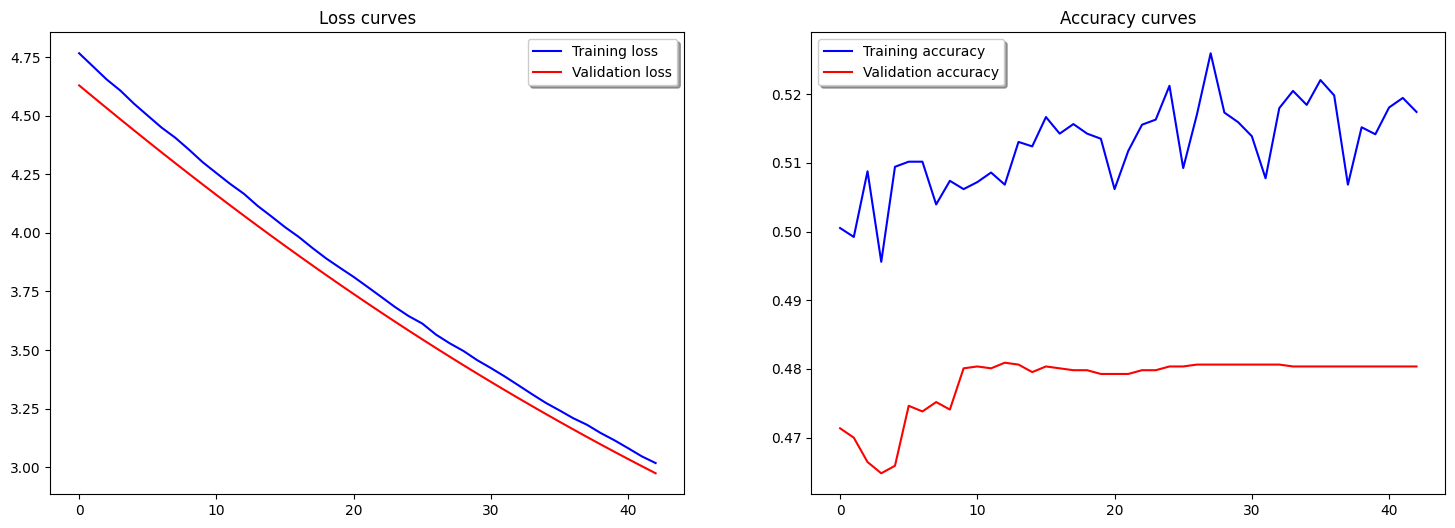

In [118]:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()
History = model.fit(X_train, detect_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_valid, detect_valid),
                    shuffle=True,verbose=0,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train, detect_train,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_valid, detect_valid,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [107]:
y_pred = model.predict(X_test, batch_size=M_TEST, verbose=1)
score = (y_pred > 0.5).sum() / len(detect_test)
print(f'Prediction accuracy = {score*100}%')

1/1 [==============================] - 1s 591ms/step
Prediction accuracy = 2.6737967914438503%
